# Plot SST data

In [1]:
import warnings 
warnings.simplefilter('ignore') 
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 
import fsspec # these libraries help reading cloud data
import s3fs
import dask
from dask.distributed import performance_report, Client, progress

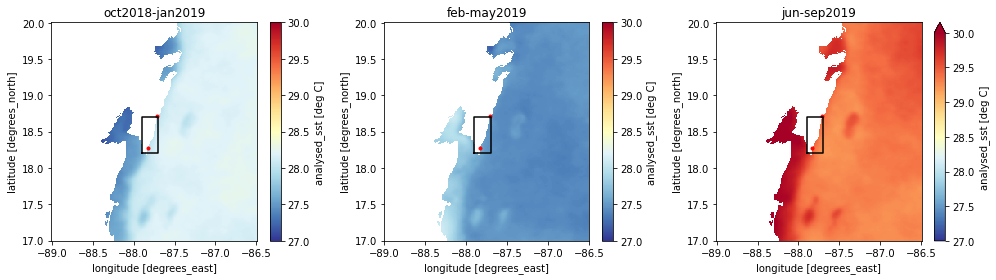

In [11]:
plt.figure(figsize=(14,4))
for i in range(3):
    if i==0:
        fn=('sst_large_oct2018-jan2019.nc')
    elif i==1:
        fn=('sst_large_feb-may2019.nc')
    else:
        fn='sst_large_jun-sep2019.nc'
    sst1=xr.open_dataset('../data/'+fn)
    sst1.close()
    sst1= sst1.analysed_sst
    
    plt.subplot(1,3,i+1)
    sst1.plot(cmap='RdYlBu_r', vmin=27, vmax=30)
    plt.plot(-87.71,18.72,'r.')
    plt.plot(-87.83,18.27,'r.')
    plt.plot([-87.9, -87.7,-87.7,-87.9,-87.9],[18.20,18.20,18.70,18.70,18.20],'k-')
    plt.title(fn[10:-3])

plt.tight_layout()

In [12]:
ssts = xr.open_dataset('../data/SST_2002-2020_small.nc') 
ssts.close()
ssts = ssts.analysed_sst # select only one variable

In [13]:
sstl = xr.open_dataset('../data/SST_2002-2020_large.nc') 
sstl.close()
sstl = sstl.analysed_sst # select only one variable

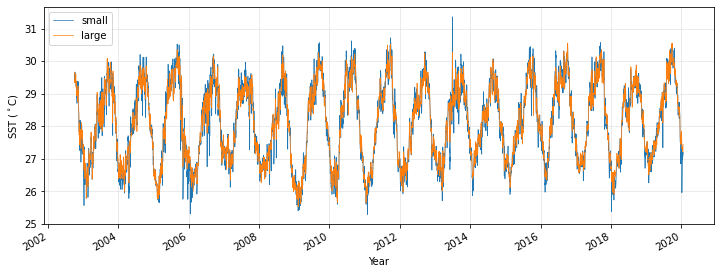

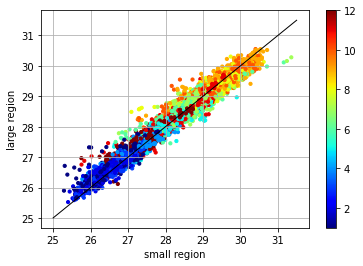

In [20]:
plt.figure(figsize=(12,4))

ssts.plot(lw=0.7, label='small') # this is all you need
sstl.plot(lw=0.7, label='large')

# all the stuff here to make it look nice. 
plt.ylabel('SST ($^\circ$C)')
plt.xlabel('Year')
plt.legend(loc=0)
plt.grid(True, alpha=0.3)
plt.show()

plt.scatter(ssts,sstl,10,ssts.time.dt.month,'o', cmap='jet')
plt.colorbar()
plt.plot([25,31.5],[25,31.5],'k-',lw=1)
plt.xlabel('small region')
plt.ylabel('large region')
plt.grid()
plt.show()

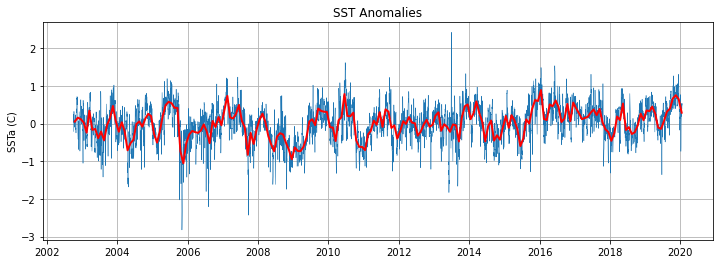

In [25]:
# Calculate the climatology
sst_climatology = ssts.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False) # Group by day, all years. skipna ignore missing (NaN) values 
sst_climstd = ssts.groupby('time.dayofyear').std('time',keep_attrs=True,skipna=False) # Calculate standard deviation. Keep data attributes.

# calculate the anomalies
sst_anomaly = ssts.groupby('time.dayofyear')-sst_climatology 
sst_anomaly_monthly = sst_anomaly.resample(time='1MS', loffset='15D').mean(keep_attrs=True,skipna=False) # calculate monthly anomalies/smoothing

# make a plot 
plt.figure(figsize=(12,4))

plt.plot(sst_anomaly.time,sst_anomaly, lw=0.5)
plt.plot(sst_anomaly_monthly.time,sst_anomaly_monthly, 'r', lw=2)

plt.grid()
plt.ylabel('SSTa (C)')
plt.title('SST Anomalies')
plt.show()


***
#### Now, a different analsys of anomalously warm SST days. 
## Marine heatwaves
Defined as any period with SST anomalies above the threshold determined by the 90th percentile value of a given period - in this case our data time period.***


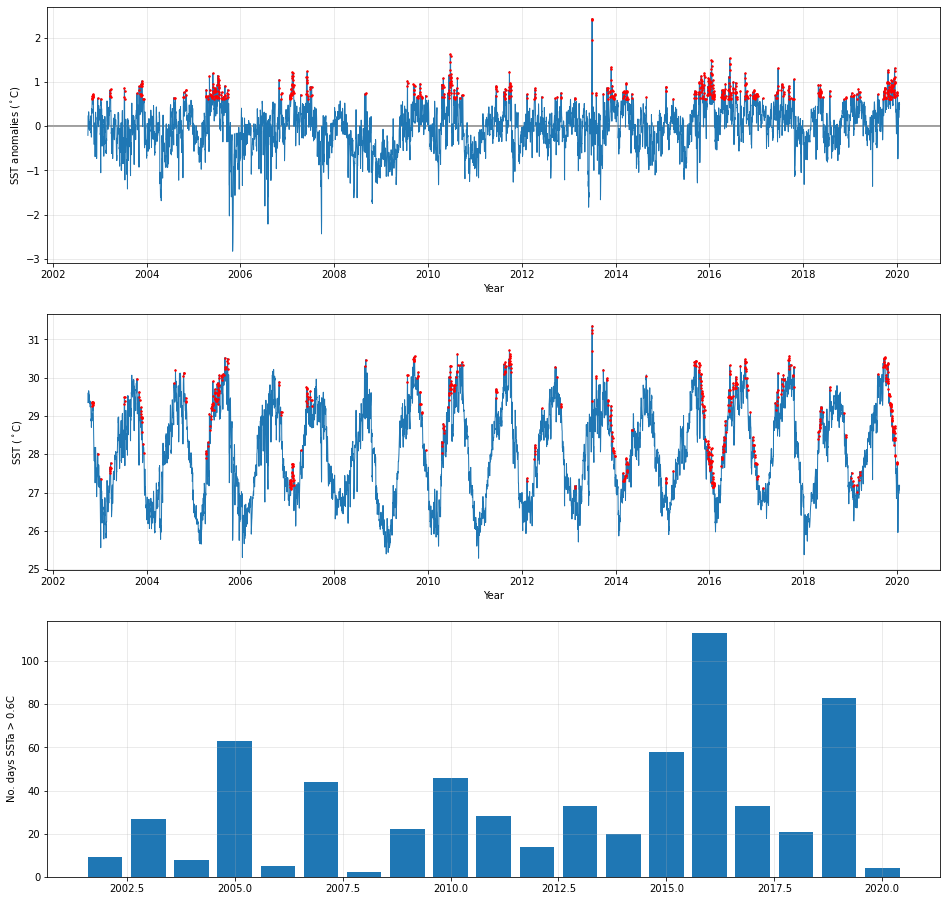

<xarray.DataArray 'time' (year: 19)>
array([  9,  27,   8,  63,   5,  44,   2,  22,  46,  28,  14,  33,  20,
        58, 113,  33,  21,  83,   4])
Coordinates:
  * year     (year) int64 2002 2003 2004 2005 2006 ... 2016 2017 2018 2019 2020

In [29]:
# first, calculate the threshold: 90th percentile
thr = np.percentile(sst_anomaly, 90)

fig, axs = plt.subplots(3,1,figsize=(16,16)) # make a figure of 3 vertical panels

# same plot as in our function above, but this time we are plotting the anomalies.
plt.subplot(3,1,1) 
plt.plot(sst_anomaly.time,sst_anomaly.data, lw=1)
plt.axhline(y=0, c='k', zorder=0, alpha=0.5) # add a line to highlight the x axis 
a=sst_anomaly>=thr # select data above the threshold
plt.plot(sst_anomaly.time[a], sst_anomaly.data[a],'.r', markersize=3)
# all stuff here to make it look good
plt.ylabel('SST anomalies ($^\circ$C)')
plt.xlabel('Year')
plt.grid(True, alpha=0.3)

# Now plot on the original data (not anomalies)
plt.subplot(3,1,2) # second panel
plt.plot(ssts.time,ssts.data, lw=1)
plt.plot(ssts.time[a], ssts.data[a],'.r', markersize=3) # plot only the values equal or above threshold
# all stuff here to make it look good
plt.ylabel('SST ($^\circ$C)')
plt.xlabel('Year')
plt.grid(True, alpha=0.3)

# plot of marine heatwave days  per year
dts = sst_anomaly[sst_anomaly>=thr].time
mhw = dts.groupby('time.year').count()
plt.subplot(3,1,3) # third panel
plt.bar(mhw.year,mhw)
plt.ylabel('No. days SSTa > '+str(np.round(thr,1))+'C')
plt.grid(True, alpha=0.3)
plt.show()

mhw # print the numbers of days